In [1]:
import os
import numpy as np
# import working directory to check functions
os.chdir('/Users/schiend/Desktop/DOHERTY/R-workspace/cecelia/inst')

# config
import py.config_utils as cfg

%load_ext autoreload
%autoreload 2

In [2]:
#base_dir = '/Volumes/USER_data/Dominik/Experiments/stomics/10x/Xenium_FFPE_Human_Breast_Cancer_Rep1_outs'
base_dir = '/Volumes/USER_data/Dominik/Experiments/stomics/10x/Xenium_V1_FF_Mouse_Brain_Coronal_Subset_CTX_HP_outs'
transcripts_path = os.path.join(base_dir, 'transcripts.csv.gz')
im_path = os.path.join(base_dir, 'morphology_mip.ome.tif')
ts_zarr_path = os.path.join(base_dir, 'ts.zarr')

In [3]:
# read transcript data
import pandas as pd

ts_data = pd.read_csv(transcripts_path, compression = 'gzip', error_bad_lines = False)
ts_data

/var/folders/rb/m9wptf8x58x_82t7lg081kfs1fj7kv/T/ipykernel_22461/935456629.py:4: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  ts_data = pd.read_csv(transcripts_path, compression = 'gzip', error_bad_lines = False)


,transcript_id,cell_id,overlaps_nucleus,feature_name,x_location,y_location,z_location,qv
0,281474976710658,7703,0,Dkk3,4820.3257,768.67926,15.693588,16.515629
1,281474976710659,7704,0,Dkk3,4820.8900,731.11847,15.173458,22.901026
2,281474976710661,7704,0,Dkk3,4821.7840,733.21240,14.517880,15.178098
3,281474976710664,7886,0,Bhlhe40,4824.4880,656.77610,15.052075,22.886139
4,281474976710665,7704,1,Bhlhe40,4825.7410,737.87180,17.312185,31.846780
...,...,...,...,...,...,...,...,...
11791432,281599531251574,35282,0,Acsbg1,3639.5240,2848.17260,14.729904,40.000000
11791433,281599531251575,35995,1,Rprm,3639.2470,2779.44730,15.175095,23.390734
11791434,281599531251577,36115,0,Sema6a,3640.4727,3067.59640,13.888914,40.000000
11791435,281599531251579,5454,1,Nell1,3639.4960,3456.90770,13.969896,40.000000


In [4]:
max_values = ts_data['qv'].max()

In [5]:
import shutil
import bioformats
import zarr

import py.ome_xml_utils as ome_xml_utils
import py.zarr_utils as zarr_utils
from py.dim_utils import DimUtils

Could not find Java JRE compatible with x86_64 architecture


In [6]:
from scipy.sparse import coo_array
import skimage.filters
import skimage.morphology

In [7]:
# get data and meta data
im_data, _ = zarr_utils.open_as_zarr(im_path)
omexml = ome_xml_utils.parse_meta(im_path)
dim_utils = DimUtils(omexml)
dim_utils.calc_image_dimensions(im_data[0].shape)
pixel_sizes = dim_utils.im_physical_sizes()

In [8]:
dim_utils.im_dim[0]

16652

In [9]:
## convert to zarr image
import math

# build up image dimensions
dim_cols = ['y_location', 'x_location']
x_min, y_min = ts_data[dim_cols].min(axis = 0)
x_max, y_max = ts_data[dim_cols].max(axis = 0)

im_dim = [
    0, 0,
    dim_utils.im_dim[0],
    dim_utils.im_dim[1]
    #crop['y'][1] - crop['y'][0],
    #crop['x'][1] - crop['x'][0]
]
im_dim

[0, 0, 16652, 25640]

In [10]:
crop = {
    'x': [20000, 25000],
    'y': [10000, 15000],
}

In [11]:
# DEBUG only use defined ones for now
channel_names = [
    # B
    'BANK1', 'CD79A', 'MS4A1',
    # T
    'CCL5', 'CD4', 'CD8A', 'CXCR4', 'CYTIP',
    'IL7R', 'LTB', 'TRAC',
    # Mphage
    #'APOC1', 'C15orf48', 'C1QA', 'C1QC', 'CD14', 
    #'CD163', 'CD68', 'FGL2', 'ITGAX', 'MMP12',
    # DC
    #'CCR7', 'CD83', 'IL3RA', 'LILRA4', 'PLD4',
    # Stroma
    #'ALDH1A3', 'GJB2', 'LUM', 'MMP2', 'POSTN', 'SFRP4'
]

In [12]:
channel_names = ts_data['feature_name'].unique()

# filter blanks
channel_names = [x for x in channel_names if x.startswith(('BLANK', 'NegControl')) is False]

In [13]:
import random
channel_names = random.sample(channel_names, 2)

In [15]:
num_channels = len(channel_names)

In [17]:
import matplotlib
import matplotlib.pyplot as plt

In [18]:
x = 'Slc17a6'

y1 = ts_data.loc[ts_data['feature_name'] == x]

# create sparse matrix
row  = y1[dim_cols[0]].values / pixel_sizes['y']
col  = y1[dim_cols[1]].values / pixel_sizes['x']
#data = y1['qv'].values
data = np.repeat(1, len(y1.index))

y2 = coo_array((data, (row, col)), shape = zarr_shape[1:3]).toarray().astype(np.uint8)

In [19]:
im_scale = 0.2125

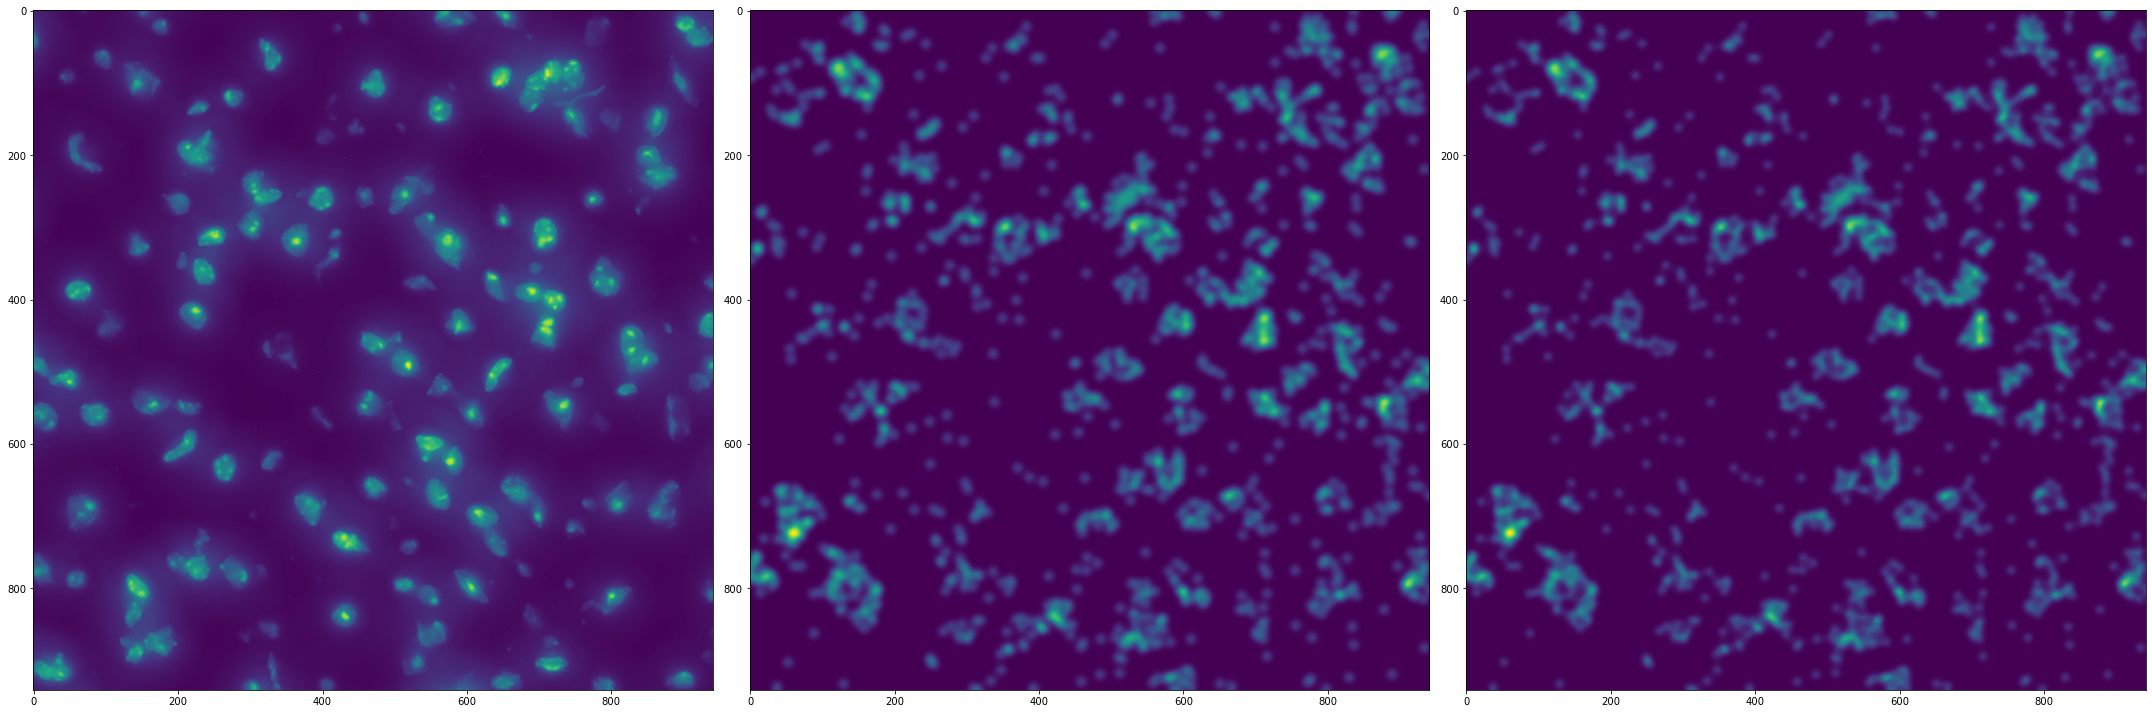

In [43]:
from skimage.color import combine_stains, rgb_from_rbd

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))

im_dapi = im_data[0][
    round(3200/im_scale):round(3400/im_scale),
    round(4400/im_scale):round(4600/im_scale)
]
im_ori = y2[
    round(3200/im_scale):round(3400/im_scale),
    round(4400/im_scale):round(4600/im_scale)
]
im_sum = skimage.filters.rank.sum(im_ori, skimage.morphology.disk(6))

# make donuts
im_filt = (skimage.filters.gaussian(im_sum, 4, preserve_range = True) * (2**8-1)).astype(np.uint16)
im_min = skimage.filters.rank.minimum(im_filt, skimage.morphology.disk(2))

axes[0].imshow(im_dapi)
axes[1].imshow(skimage.filters.median(im_filt, skimage.morphology.disk(4)))
axes[2].imshow(skimage.filters.median(im_min, skimage.morphology.disk(4)))

plt.tight_layout()
plt.show()

In [16]:
# create zarr
zarr_shape = (
    num_channels,
    im_dim[2] - im_dim[0],
    im_dim[3] - im_dim[1],
    #im_dim[5] - im_dim[2]
)
  
seq_image = zarr.open(
    #ts_zarr_path,
    mode = 'w',
    shape = zarr_shape,
    # chunks = (1, 512, 512),
    chunks = tuple([1] + list(im_data[0].chunks)),
    dtype = np.uint16
)

In [ ]:
filter_value = 2
min_filter_value = 4
sum_value = 6

if os.path.exists(ts_zarr_path):
    shutil.rmtree(ts_zarr_path)

# go through and create images
for i, x in enumerate(channel_names):
    print(x)
    
    y1 = ts_data.loc[ts_data['feature_name'] == x]
    
    # create sparse matrix
    row  = y1[dim_cols[0]].values / pixel_sizes['y']
    col  = y1[dim_cols[1]].values / pixel_sizes['x']
    #data = y1['qv'].values
    data = np.repeat(1, len(y1.index))

    y2 = coo_array((data, (row, col)), shape = zarr_shape[1:3]).toarray().astype(np.uint8)
    
    # TODO use Dask?
    # sum
    seq_image[i, :, :] = skimage.filters.rank.sum(
        y2, skimage.morphology.disk(sum_value))
    
    # enhance donuts
    seq_image[i, :, :] = (skimage.filters.gaussian(seq_image[i, :, :], filter_value, preserve_range = True) * (2**8-1)).astype(np.uint16)
    seq_image[i, :, :] = skimage.filters.rank.minimum(seq_image[i, :, :], skimage.morphology.disk(min_filter_value))
    seq_image[i, :, :] = skimage.filters.median(seq_image[i, :, :], skimage.morphology.disk(filter_value))
    
# generate multiscales 
nscales = len(im_data)

# TODO is there a more elegant way to do this .. ?
if nscales > 1:
    multiscales_file_path = ts_zarr_path + ".multiscales"

zarr_utils.create_multiscales(
  seq_image, multiscales_file_path,
  x_idx = 1, y_idx = 2,
  nscales = nscales
)

# remove previous and rename multiscales
if os.path.exists(ts_zarr_path):
    shutil.rmtree(ts_zarr_path)
os.rename(multiscales_file_path, ts_zarr_path)

In [ ]:
# build metadata
o = bioformats.omexml.OMEXML()

# TODO anything else?
o.image().Pixels.channel_count = zarr_shape[0]
o.image().Pixels.set_SizeC(zarr_shape[0])
o.image().Pixels.set_SizeX(zarr_shape[2])
o.image().Pixels.set_SizeY(zarr_shape[1])
o.image().Pixels.set_PhysicalSizeX(pixel_sizes['x'])
o.image().Pixels.set_PhysicalSizeY(pixel_sizes['y'])
o.image().Pixels.set_PhysicalSizeXUnit('um')
o.image().Pixels.set_PhysicalSizeYUnit('um')
o.image().Pixels.set_PixelType('uint16')

#for i, x in enumerate(channel_names[0:num_channels]):
for i, x in enumerate(channel_names):
    o.image().Pixels.Channel(i).Name = x

# add metadata
ome_xml_utils.write_ome_xml(ts_zarr_path, o)

In [ ]:
napari_utils.open_image(
    ts_zarr_path, use_channel_axis = True, as_dask = True, 
    channel_names = channel_names, visible = False,
)

In [ ]:
# read in OME XML from first image sequence
import tifffile
import py.zarr_utils as zarr_utils
import py.ome_xml_utils as ome_xml_utils
from py.dim_utils import DimUtils

im = tifffile.TiffFile(im_path)
x_array = im.asarray()
omexml = ome_xml_utils.parse_meta(im_path)
dim_utils = DimUtils(omexml)
dim_utils.calc_image_dimensions(x_array.shape)

In [ ]:
# split y axis
# TODO this is specific to Thorlabs 3P output
split_size = int(dim_utils.dim_val('Y')/dim_utils.dim_val('X'))

In [ ]:
# DEBUG take first x slices
debug_slices = 12
debug_start_slice = 48

In [ ]:
# split array along Y
x_split = np.array_split(x_array, split_size, axis = dim_utils.dim_idx('Y'))

In [ ]:
x_split = [x[debug_start_slice:(debug_start_slice + debug_slices), :, :, :] for x in x_split]

In [ ]:
stack_dim = 'Z'
skip_tiles = 1
nscales = 1
physical_stack_scale = 2

In [ ]:
# get or create stack axis
stack_dim_idx = dim_utils.dim_idx(stack_dim)
stack_array = False

# check whether to create this dimension
if stack_dim_idx is None:
    stack_dim_idx = dim_utils.default_order.index(stack_dim)
    stack_array = True

In [ ]:
import math

In [ ]:
"""
scale intensity
exp[𝑚𝑛(Δ𝑧/ls − ln(𝑠))] 
m - multiphoton number
n - plane index
s - relative incident laser power ratio between planes
d𝑧 - spacing between planes
ls - mean free path
"""
def reverb_intensity_scale(m, n, s, dz, ls, x = None, scale = None):
    # get y 
    y = 1/math.exp(m * n * (dz/ls - math.log(s)))
    
    # scale?
    if scale is not None:
        y = y/scale
    
    if x is not None:
        return (x * y).astype(x.dtype)
    else:
        return y

In [ ]:
m = 3
s = 2
dz = 26
ls = 200

In [ ]:
reverb_intensity_scale(m, len(x_split_shift[::(skip_tiles + 1)]), s, dz, ls)

In [ ]:
# create shifts to create image
shifts = np.array([
    [14.74, -2.18],
    [14.74, -2.18],
    [13.41, 16.31],
    [13.41, 16.31],
    [8.92, -4.23],
    [8.92, -4.23]
])

In [ ]:
# generate slices for images
shift_slices_target = [[slice(None) for _ in x_array.shape] for _ in range(len(shifts))]
shift_slices_source = [[slice(None) for _ in x_array.shape] for _ in range(len(shifts))]
dim_val = dim_utils.dim_val('X')

for i, shift in enumerate(shifts):
    # create slices for source and target
    if shift[0] > 0:
        shift_slices_target[i][dim_utils.dim_idx('Y')] = slice(round(shift[0]), dim_val, 1)
        shift_slices_source[i][dim_utils.dim_idx('Y')] = slice(0, dim_val - round(shift[0]), 1)
    else:
        shift_slices_target[i][dim_utils.dim_idx('Y')] = slice(0, dim_val + round(shift[0]), 1)
        shift_slices_source[i][dim_utils.dim_idx('Y')] = slice(-round(shift[0]), dim_val, 1)
        
    if shift[1] > 0:
        shift_slices_target[i][dim_utils.dim_idx('X')] = slice(round(shift[1]), dim_val, 1)
        shift_slices_source[i][dim_utils.dim_idx('X')] = slice(0, dim_val - round(shift[1]), 1)
    else:
        shift_slices_target[i][dim_utils.dim_idx('X')] = slice(0, dim_val + round(shift[1]), 1)
        shift_slices_source[i][dim_utils.dim_idx('X')] = slice(-round(shift[1]), dim_val, 1)
    
shift_slices_target = [tuple(x) for x in shift_slices_target]
shift_slices_source = [tuple(x) for x in shift_slices_source]

In [ ]:
x_split_shift = x_split[:2]

# generate new image
for i, x in enumerate(x_split[2:]):
    # zero image
    zero_im = np.zeros_like(x)
    
    # copy image
    zero_im[shift_slices_target[i]] = x[shift_slices_source[i]]
    # zero_im[shift_slices_source[i]] = x[shift_slices_target[i]]
    
    x_split_shift.append(zero_im)

In [ ]:
 if stack_array is True:
    x_new = np.stack(
        [reverb_intensity_scale(x, m, n + 1, s, dz, ls) \
         for n, x in enumerate(x_split[::(skip_tiles + 1)])],
        axis = stack_dim_idx
    )
else:
    # get max reverb scale
    max_scale = reverb_intensity_scale(m, len(x_split_shift[::(skip_tiles + 1)]), s, dz, ls)
    
    # contact with shift slices
    x_new_list = [reverb_intensity_scale(m, n + 1, s, dz, ls, x = x, scale = max_scale) \
         for n, x in enumerate(x_split_shift[::(skip_tiles + 1)])]
    x_new_list.reverse()
    
    x_new = np.concatenate(x_new_list, axis = stack_dim_idx)

In [ ]:
# use median filter
from skimage.filters.rank import median
from skimage.morphology import ball

In [ ]:
im_slices = [slice(None) for _ in range(len(x_new.shape))]

for i in range(dim_utils.dim_val('C')):
    im_slices = list(im_slices)
    im_slices[dim_utils.dim_idx('C')] = i
    im_slices = tuple(im_slices)
    
    x_new[im_slices] = median(x_new[im_slices], ball(3))

In [ ]:
zarr_utils.create_multiscales(x_new, zarr_path, nscales = nscales)

In [ ]:
# create shape dict for new image
shape_dict = {'Y': int(dim_utils.dim_val('Y')/split_size)}
shape_dict[stack_dim.upper()] = x_new.shape[stack_dim_idx]
scale_dict = dict()
scale_dict[stack_dim.upper()] = physical_stack_scale

# change image dimensions in xml
omexml_new = ome_xml_utils.set_im_size_with_dict(omexml, shape_dict)
omexml_new = ome_xml_utils.set_physical_size_with_dict(omexml_new, scale_dict)

# add metadata
ome_xml_utils.write_ome_xml(zarr_path, omexml_new)

In [ ]:
from py.napari_utils import NapariUtils

napari_utils = NapariUtils()
napari_utils.viewer = None
napari_utils.open_viewer()

In [ ]:
channel_names = [
    'A', 'B', 'C', 'D'
]

In [ ]:
napari_utils.open_image(
    zarr_path,
    use_channel_axis = True, as_dask = True,
    channel_names = channel_names
)

In [ ]:
from napari_animation import AnimationWidget
animation_widget = AnimationWidget(napari_utils.viewer)
napari_utils.viewer.window.add_dock_widget(animation_widget, area='right')